# Concrete Prediction Model Protoype #1

**Purpose:** 
The aim of this notebook is to develop a supervised regression model predicting Compressive strength 28days MPa. 

**Data:** This analysis is based on a csv file containing testing data for 163 concrete samples. There were a total of 60 columns excluding the two target variables (Compressive strength 7days/28days MPa).

**Note:** 
Due to the sensitivity/privacy of this engagement, exploratory data analysis and the final features used for the project have been excluded.


**Author:** 
Adam Tassabehji

If you have any questions please do not hesitate to contact me at atassabehji@gmail.com



### Table of Contents

* [1. Importing Data and Packages](#one)
* [2. Exploratory Data Analysis](#two)
* [3. Data Cleaning](#three)
* [4. Feature Engineering](#four)
* [5. Feature Selection](#five)
* [6. Modelling](#six)
    * [Linear Regression vs Decision Tree  (Illustrative Example)](#sixone)
    * [Inferential Linear Regression Model](#sixtwo)
    * [Regression Model Comparison](#sixthree)
* [7. Hypertuning and Ensembling](#seven)
* [8. Final Summary and Model Selection](#eight)
* [9. Appendix](#app)

### 1. Importing Data and Packages  <a class="anchor" id="one"></a>

In [69]:
import pandas as pd
import numpy as np
from numpy import mean,std

from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,RepeatedKFold,learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,cross_val_score,ShuffleSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,StandardScaler
from sklearn.metrics import mean_squared_error,accuracy_score,r2_score

from category_encoders import TargetEncoder
from sklearn.impute import KNNImputer
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import mutual_info_regression,SelectKBest,f_regression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,HuberRegressor, LinearRegression,LassoLarsCV
from sklearn.linear_model import LinearRegression,Ridge,Lars,TheilSenRegressor,PassiveAggressiveRegressor
from sklearn.linear_model import ARDRegression,BayesianRidge,ElasticNet
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,StackingRegressor,VotingRegressor

import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
import catboost as cb

import time
import timeit
import beepy as beep


In [70]:
#np.random.seed(0)
start = timeit.default_timer()

In [71]:
## Reading the data file
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data=pd.read_csv('Concrete_Strength_Datasetv7.csv')

### 2. Exploratory Data Analysis  <a class="anchor" id="two"></a>

In [72]:
print(f'''There are a total of {data.shape[1]} columns and {data.shape[0]} rows''')

There are a total of 62 columns and 163 rows


### 3. Data Cleaning (Seperate Notebook) <a class="anchor" id="three"></a>

**Identifying the Target Variable**

In [76]:
## Renaming for easier identification
data = data.rename(columns={'Compressive strength 28days MPa ': 'Target'})
data.columns=data.columns.str.replace(' ','_')

**Dropping rows missing the target variable**

In [77]:
## We can't do any predictions for samples missng this information
data=data[data['Target'].notna()]

In [78]:
print(f'''There are a total of {data.shape[1]} columns and {data.shape[0]} rows''')

There are a total of 62 columns and 160 rows


**Dropping Columns that have more than 20% of missing values**

In [79]:
perc = 20.0 
min_count =  int(((100-perc)/100)*data.shape[0] + 1)
data = data.dropna( axis=1, thresh=min_count)

In [80]:
print(f'''There are a total of {data.shape[1]} columns and {data.shape[0]} rows''')

There are a total of 32 columns and 160 rows


In [81]:
cols = data.columns
num_cols = data._get_numeric_data().columns

cat_cols=list(set(cols)-set(num_cols))

print(f'''There are a total of {len(num_cols)} numerical columns''')

print(f'''There are a total of {len(cat_cols)} categorical columns''')

There are a total of 29 numerical columns
There are a total of 3 categorical columns


**Transformating Categorical Variables**

In [82]:
## Creating Concrete Grade variable from Concrete_Grade_/_Batch_Plant_No.

data['Concrete_Grade']=data['Concrete_Grade_/_Batch_Plant_No.'].str[:3].map(lambda x:'C70' if x =='Flo' else x)

In [83]:
## Target Encoding for Concreate Grade & Supplier

encoder = TargetEncoder()

data['Concrete_Grade_Target'] = encoder.fit_transform(data['Concrete_Grade'], data['Target'])

encoder = TargetEncoder()

data['Supplier_Target'] = encoder.fit_transform(data['Supplier'], data['Target'])

/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [84]:
data=data.drop(['Supplier','Prop_Name_A','Concrete_Grade_/_Batch_Plant_No.','Concrete_Grade'], axis=1)

**Dealing with Outliers**

<AxesSubplot:xlabel='Fine_Agg_Density_(ASTM_C128)_Kg/m3'>

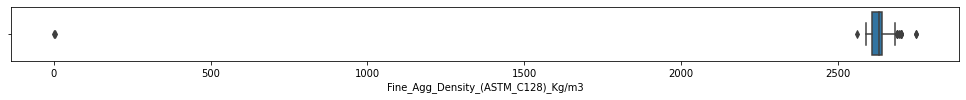

In [85]:
## We can see below that some variables suffer from outliers/incorrect entries

plt.figure(figsize=(17,1))
sns.boxplot(x=data['Fine_Agg_Density_(ASTM_C128)_Kg/m3'])

In [86]:
## Replacing them with the 3% and 97% quantiles

cols=data.columns[data.columns!='Target']

for col in cols:
    lower=data[col].quantile(0.03)
    upper=data[col].quantile(0.97)
    data[col]=np.where(data[col] <lower, lower,data[col])
    data[col]=np.where(data[col] >upper, upper,data[col])

<AxesSubplot:xlabel='Fine_Agg_Density_(ASTM_C128)_Kg/m3'>

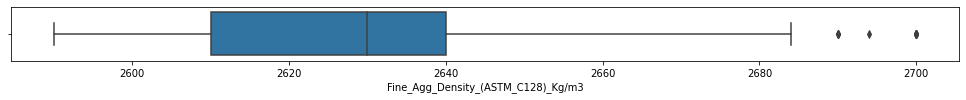

In [87]:
plt.figure(figsize=(17,1))
sns.boxplot(x=data['Fine_Agg_Density_(ASTM_C128)_Kg/m3'])

**Imputing Missing Values for Numerical (KNN)**

- This imputer utilizes the k-Nearest Neighbors method to replace the missing values in the datasets with the mean value from the parameter ‘n_neighbors’ nearest neighbors found. By default, it uses a Euclidean distance metric to impute the missing values. 

- In Layman's terms, for each row missing a certain value it identifies the 5 most similar rows and imputes a value that fits.

In [88]:
data=data.reset_index(drop=True)
X=data.drop(['Target','Compressive_strength_7days_MPa_'],axis=1)
y=data['Target']

In [89]:
## Scaling or normalizing the data enables more accurate imputation
scaler = StandardScaler()
scaler.fit(X)
X=pd.DataFrame(scaler.transform(X),index=X.index, columns=X.columns)

In [90]:
## Performing the imputation
imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(imputer.fit_transform(X),columns = X.columns).astype(float)

### 4. Feature Engineering  <a class="anchor" id="four"></a>

**Polynomial features** are created by raising existing features to an exponent.

For example, if a dataset had one input feature X, then a polynomial feature would be the addition of a new feature (column) where values were calculated by squaring the values in X, e.g. X^2. This process can be repeated for each input variable in the dataset, creating a transformed version of each. It will also explore the iteractions of different variables by multiplying them.

In [91]:

poly_feats = PolynomialFeatures(degree=2)
X_cross= X
crossed_features = poly_feats.fit_transform(X_cross)

X = pd.DataFrame(crossed_features,columns=poly_feats.get_feature_names(X_cross.columns)).reindex(X.index)


In [92]:
print(f'Total number of features: {len(X.columns)}')

Total number of features: 465


### 5. Feature Selection  <a class="anchor" id="five"></a>

- This portion of the notebook will be dedicated towards identifying and selecting the variables with the highest predictive power. 

- Initially a univarite test will be conducted (filter), followed by a multivariate test (wrapper).

**Method 1:**

Select K-best (Univariate)

In [93]:
## Filtering for the top 100 variables by building univariate regresssion models 

fs = SelectKBest(score_func=f_regression,k=100)
X_selected = fs.fit_transform(X, y)

## Identifying the names and filtering for the columns
cols = fs.get_support(indices=True)
X=X[X.columns[cols]]
X.columns

/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Index(['Prop_Cement_Kg', 'Prop_Silica_Fume_kg', 'Prop_Free_Water_kg',
       'Prop_3/4"_Agg._SSD_kg', 'Prop_Sand_SSD_kg', 'Prop_Admixture1_kg',
       'Co_Agg_Loss_Angeles_Abrasion_Value_(ASTM_C131)_Agg1_(%)',
       'Co_Agg_Soundness_(ASTM_C88)_Agg1_(%)',
       'Co_Agg_Clay_lumps_and_friable_particles_(ASTM_C142M)_Agg1_(%)',
       'Co_Agg_Clay_lumps_and_friable_particles_(ASTM_C142M)_Agg2_(%)',
       'Co_Agg_Absorption_(ASTM_C127)_Agg1_(%)',
       'Fine_Agg_Soundness_(ASTM_C88)_(%)',
       'Fine_Agg_Absorption_(ASTM_C128)_(%)', 'Concrete_Grade_Target',
       'Supplier_Target', 'Prop_Cement_Kg Prop_Silica_Fume_kg',
       'Prop_Cement_Kg Prop_3/4"_Agg._SSD_kg',
       'Prop_Cement_Kg Co_Agg_Aggregate_Sizes_Agg1_(in)',
       'Prop_Cement_Kg Co_Agg_Loss_Angeles_Abrasion_Value_(ASTM_C131)_Agg2_(%)',
       'Prop_Cement_Kg Co_Agg_Density_(ASTM_C127)_Agg2_Kg/m3',
       'Pro_Fly_Ash_Kg Prop_Silica_Fume_kg',
       'Pro_Fly_Ash_Kg Co_Agg_Loss_Angeles_Abrasion_Value_(ASTM_C131)_Agg1_(%

**Method 2 ( Stepwise Forward Selection)**

This will identify the optimal number of variables by testing different combinations

In [94]:
sfs1 = SFS(LinearRegression(),
           k_features=(2,16),
           forward=True,
           floating=True,
           cv=4)
sfs1.fit(X, y)

SequentialFeatureSelector(cv=4, estimator=LinearRegression(), floating=True,
                          k_features=(2, 16))

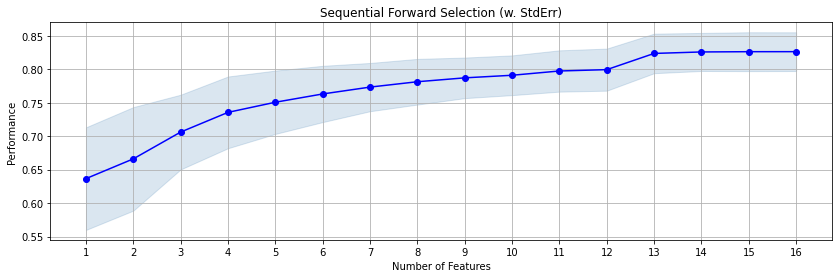

In [95]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err',figsize=(14, 4))


plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [96]:
print(f'{len(sfs1.k_feature_names_)} Features and R2 Score: {sfs1.k_score_}')

16 Features and R2 Score: 0.8262907761948718


In [97]:
## These are the variables we will select for the next stage
predictors=list(sfs1.k_feature_names_)
predictors

['Prop_Cement_Kg',
 'Concrete_Grade_Target',
 'Prop_Cement_Kg Prop_3/4"_Agg._SSD_kg',
 'Prop_Cement_Kg Co_Agg_Aggregate_Sizes_Agg1_(in)',
 'Prop_Cement_Kg Co_Agg_Density_(ASTM_C127)_Agg2_Kg/m3',
 'Pro_Fly_Ash_Kg Prop_Silica_Fume_kg',
 'Prop_Silica_Fume_kg Concrete_Grade_Target',
 'Prop_3/4"_Agg._SSD_kg Co_Agg_Clay_lumps_and_friable_particles_(ASTM_C142M)_Agg1_(%)',
 'Prop_3/4"_Agg._SSD_kg Concrete_Grade_Target',
 'Prop_Sand_SSD_kg^2',
 'Co_Agg_Loss_Angeles_Abrasion_Value_(ASTM_C131)_Agg1_(%) Co_Agg_Material_finer_than_0.075_mm_(ASTM_C117)_Agg1_(%)',
 'Co_Agg_Loss_Angeles_Abrasion_Value_(ASTM_C131)_Agg1_(%) Fine_Agg_Soundness_(ASTM_C88)_(%)',
 'Co_Agg_Soundness_(ASTM_C88)_Agg1_(%) Co_Agg_Density_(ASTM_C127)_Agg1_Kg/m3',
 'Co_Agg_Clay_lumps_and_friable_particles_(ASTM_C142M)_Agg1_(%) Co_Agg_Absorption_(ASTM_C127)_Agg2_(%)',
 'Co_Agg_Density_(ASTM_C127)_Agg2_Kg/m3 Fine_Agg_Material_finer_than_0.075_mm_(ASTM_C117)_(%)',
 'Fine_Agg_Density_(ASTM_C128)_Kg/m3 Fine_Agg_Absorption_(ASTM_C128)_(

In [98]:
X=X[predictors]

### 6. Modelling <a class="anchor" id="six"></a>

In [99]:
## Splitting Train and Test data (70% train to train the model and 30% to test predictions)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=1995)

#### 6.1 Simple Linear Regression  vs Decision Tree (Illustrative Example)<a class="anchor" id="sixone"></a>

In [100]:
X_train_viz=np.array(X_train['Prop_Cement_Kg']).reshape(-1, 1)
X_test_viz=np.array(X_test['Prop_Cement_Kg']).reshape(-1, 1)

In [101]:
lr = LinearRegression()
dt = DecisionTreeRegressor()

**Fitting the Model with Train Data**

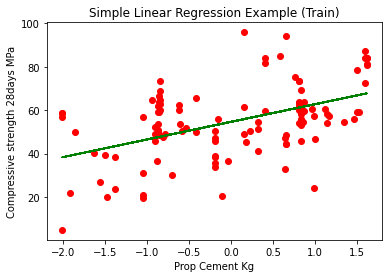

In [102]:
## Linear Regression
lr.fit(X_train_viz,y_train)

plt.scatter(X_train_viz, y_train, color = "red")
plt.plot(X_train_viz, lr.predict(X_train_viz), color = "green")
plt.title("Simple Linear Regression Example (Train)")
plt.xlabel("Prop Cement Kg")
plt.ylabel("Compressive strength 28days MPa")
plt.show()

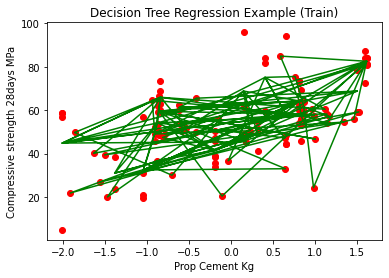

In [103]:
## Decision Tree Regression
dt.fit(X_train_viz,y_train)

plt.scatter(X_train_viz, y_train, color = "red")
plt.plot(X_train_viz, dt.predict(X_train_viz), color = "green")
plt.title("Decision Tree Regression Example (Train)")
plt.xlabel("Prop Cement Kg")
plt.ylabel("Compressive strength 28days MPa")
plt.show()

**Model Predictions with Test Data**

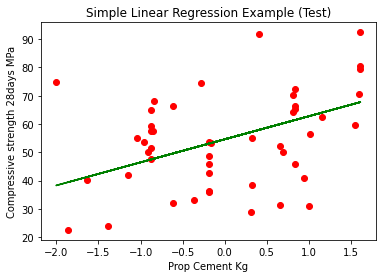

In [104]:
## Linear Regression

plt.scatter(X_test_viz, y_test, color = "red")
plt.plot(X_test_viz, lr.predict(X_test_viz), color = "green")
plt.title("Simple Linear Regression Example (Test)")
plt.xlabel("Prop Cement Kg")
plt.ylabel("Compressive strength 28days MPa")
plt.show()

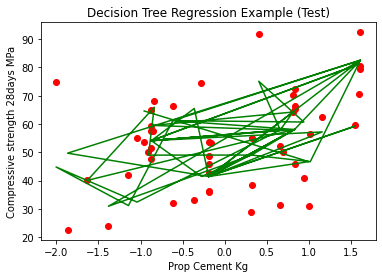

In [105]:
## Decision Tree Regression

plt.scatter(X_test_viz, y_test, color = "red")
plt.plot(X_test_viz, dt.predict(X_test_viz), color = "green")
plt.title("Decision Tree Regression Example (Test)")
plt.xlabel("Prop Cement Kg")
plt.ylabel("Compressive strength 28days MPa")
plt.show()

**Conclusion: A linear model is more appropriate due to the small sample size and risk of overfitting**

#### 6.2  Inferential Linear Regression Model  <a class="anchor" id="sixtwo"></a>

We will now fit all the data (train and test) to get a sense of the predictive power of the model and remove any insignificant variables

In [106]:
X_full_model = sm.add_constant(X)
model = sm.OLS(y,X_full_model)
result = model.fit()
result.summary()

/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     57.54
Date:                Sat, 11 Jun 2022   Prob (F-statistic):           5.01e-54
Time:                        09:29:12   Log-Likelihood:                -517.47
No. Observations:                 160   AIC:                             1069.
Df Residuals:                     143   BIC:                             1121.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================================================================
                                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                               54.9835      0.921     59.689      0.000      53.163      56.804
Prop_Cement_Kg                                                                                                       2.1132      0.766      2.759      0.007       0.599       3.627
Concrete_Grade_Target                                                                                               11.1397      0.706     15.774      0.000       9.744      12.536
Prop_Cement_Kg Prop_3/4"_Agg._SSD_kg                                                                                 2.9162      1.161      2.511      0.013       0.620       5.212
Prop_Cement_Kg Co_Agg_Aggregate_Sizes_Agg1_(in)                                                                     -1.3047      1.166     -1.119      0.265      -3.610       1.001
Prop_Cement_Kg Co_Agg_Density_(ASTM_C127)_Agg2_Kg/m3                                                                 3.4666      0.917      3.779      0.000       1.653       5.280
Pro_Fly_Ash_Kg Prop_Silica_Fume_kg                                                                                  -1.0886      0.838     -1.300      0.196      -2.744       0.567
Prop_Silica_Fume_kg Concrete_Grade_Target                                                                            1.9095      0.666      2.865      0.005       0.592       3.227
Prop_3/4"_Agg._SSD_kg Co_Agg_Clay_lumps_and_friable_particles_(ASTM_C142M)_Agg1_(%)                                  2.2407      0.731      3.064      0.003       0.795       3.686
Prop_3/4"_Agg._SSD_kg Concrete_Grade_Target                                                                          0.3787      0.747      0.507      0.613      -1.097       1.855
Prop_Sand_SSD_kg^2                                                                                                  -2.2495      0.413     -5.444      0.000      -3.066      -1.433
Co_Agg_Loss_Angeles_Abrasion_Value_(ASTM_C131)_Agg1_(%) Co_Agg_Material_finer_than_0.075_mm_(ASTM_C117)_Agg1_(%)    -0.6446      0.773     -0.834      0.406      -2.173       0.884
Co_Agg_Loss_Angeles_Abrasion_Value_(ASTM_C131)_Agg1_(%) Fine_Agg_Soundness_(ASTM_C88)_(%)                            4.0711      1.260      3.232      0.002       1.581       6.561
Co_Agg_Soundness_(ASTM_C88)_Agg1_(%) Co_Agg_Density_(ASTM_C127)_Agg1_Kg/m3                                          -3.2335      0.716     -4.514      0.000      -4.650      -1.817
Co_Agg

In [107]:

## These variables had very high p values, indicating they don't have a statistically significant
## relationship with the target variable

X=X.drop(['Prop_3/4"_Agg._SSD_kg Concrete_Grade_Target',
         'Prop_Cement_Kg Co_Agg_Aggregate_Sizes_Agg1_(in)',
        'Co_Agg_Loss_Angeles_Abrasion_Value_(ASTM_C131)_Agg1_(%) Co_Agg_Material_finer_than_0.075_mm_(ASTM_C117)_Agg1_(%)'],
         axis=1)

- Examining the p values below, we can see that all variables are statistically significant at a level >90%
- Adjusted R squared has also increased

In [108]:
X_full_model = sm.add_constant(X)
model = sm.OLS(y,X_full_model)
result = model.fit()
result.summary()

/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     71.13
Date:                Sat, 11 Jun 2022   Prob (F-statistic):           2.39e-56
Time:                        09:29:12   Log-Likelihood:                -518.60
No. Observations:                 160   AIC:                             1065.
Df Residuals:                     146   BIC:                             1108.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================================================
                                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                   54.7963      0.885     61.947      0.000      53.048      56.544
Prop_Cement_Kg                                                                                           1.8788      0.691      2.721      0.007       0.514       3.244
Concrete_Grade_Target                                                                                   11.3113      0.671     16.846      0.000       9.984      12.638
Prop_Cement_Kg Prop_3/4"_Agg._SSD_kg                                                                     2.2728      0.626      3.629      0.000       1.035       3.510
Prop_Cement_Kg Co_Agg_Density_(ASTM_C127)_Agg2_Kg/m3                                                     3.3099      0.873      3.790      0.000       1.584       5.036
Pro_Fly_Ash_Kg Prop_Silica_Fume_kg                                                                      -1.3919      0.793     -1.755      0.081      -2.959       0.175
Prop_Silica_Fume_kg Concrete_Grade_Target                                                                2.0964      0.647      3.241      0.001       0.818       3.375
Prop_3/4"_Agg._SSD_kg Co_Agg_Clay_lumps_and_friable_particles_(ASTM_C142M)_Agg1_(%)                      2.1526      0.660      3.264      0.001       0.849       3.456
Prop_Sand_SSD_kg^2                                                                                      -2.1015      0.380     -5.526      0.000      -2.853      -1.350
Co_Agg_Loss_Angeles_Abrasion_Value_(ASTM_C131)_Agg1_(%) Fine_Agg_Soundness_(ASTM_C88)_(%)                4.4168      1.182      3.736      0.000       2.080       6.753
Co_Agg_Soundness_(ASTM_C88)_Agg1_(%) Co_Agg_Density_(ASTM_C127)_Agg1_Kg/m3                              -2.9540      0.642     -4.598      0.000      -4.224      -1.684
Co_Agg_Clay_lumps_and_friable_particles_(ASTM_C142M)_Agg1_(%) Co_Agg_Absorption_(ASTM_C127)_Agg2_(%)     1.2623      0.679      1.858      0.065      -0.080       2.605
Co_Agg_Density_(ASTM_C127)_Agg2_Kg/m3 Fine_Agg_Material_finer_than_0.075_mm_(ASTM_C117)_(%)             -1.5221      0.534     -2.851      0.005      -2.577      -0.467
Fine_Agg_Density_(ASTM_C128)_Kg/m3 Fine_Agg_Absorption_(ASTM_C128)_(%)                                  -1.4727      0.688     -2.141      0.034      -2.832      -0.113
==============================================================================
Omnibus:                       17.441   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.000   Jarque-Bera 

#### 6.3 Model Comparison <a class="anchor" id="sixthree"></a>

We will now compute predictions for a variety of different linear and non-linear models

In [109]:
regressors = {
    "XGBRegressor": XGBRegressor(),
    "LGBMRegressor": lgb.LGBMRegressor(),
    "CATBoostRegressor": cb.CatBoostRegressor(verbose=False),
    'AdaBoostRegressor':AdaBoostRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "Lasso": linear_model.Lasso(),
    "LinearRegression": LinearRegression(),
    "Ridge":Ridge(),
    "Lars": Lars(),
    "TheilSenRegressor": TheilSenRegressor(),
    "HuberRegressor": HuberRegressor(),
    "ARDRegression": ARDRegression(),
    "BayesianRidge": BayesianRidge(),
    "ElasticNet": ElasticNet(),
}

In [110]:
## This will create a summary table for the results

df_models = pd.DataFrame(columns=['model', 'run_time', 'r2_train','r2_test','r2_cv','rmse'])

for key in regressors:

    print('*',key)

    start_time = time.time()

    regressor = regressors[key]
    model = regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores = cross_val_score(model, 
                             X, 
                             y,
                             scoring="r2", 
                             cv=10)

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'r2_train': regressor.score(X_train, y_train),
           'r2_test' : regressor.score(X_test, y_test),
           'r2_cv': np.mean(scores),
           'rmse': mean_squared_error(y_test, y_pred, squared=False)
           
    }

    df_models = df_models.append(row, ignore_index=True)

* XGBRegressor
* LGBMRegressor
* CATBoostRegressor
* AdaBoostRegressor
* RandomForestRegressor
* DecisionTreeRegressor
* Lasso
* LinearRegression
* Ridge
* Lars
* TheilSenRegressor
* HuberRegressor
* ARDRegression
* BayesianRidge
* ElasticNet


In [111]:
## Below is a summary of performance

df_models=df_models.sort_values(by='r2_cv', ascending=False)
df_models

,model,run_time,r2_train,r2_test,r2_cv,rmse
7,LinearRegression,0.0,0.855535,0.877655,0.712705,5.808755
9,Lars,0.0,0.855535,0.877655,0.712705,5.808755
8,Ridge,0.0,0.855403,0.879889,0.712703,5.755458
13,BayesianRidge,0.0,0.854036,0.883519,0.711238,5.667818
11,HuberRegressor,0.0,0.841056,0.876390,0.691598,5.838688
12,ARDRegression,0.0,0.846841,0.878181,0.673999,5.796243
10,TheilSenRegressor,0.16,0.828360,0.884277,0.639270,5.649352
6,Lasso,0.0,0.799005,0.826743,0.551257,6.912488
4,RandomForestRegressor,0.04,0.963444,0.803751,0.519211,7.356867
14,ElasticNet,0.0,0.748552,0.795611,0.494978,7.507883


- As seen in the graph below, non-linear models overfitted 
- This means that when predicting train score data, they performed very well but performed poorly using test data
- Linear models had a much better balance

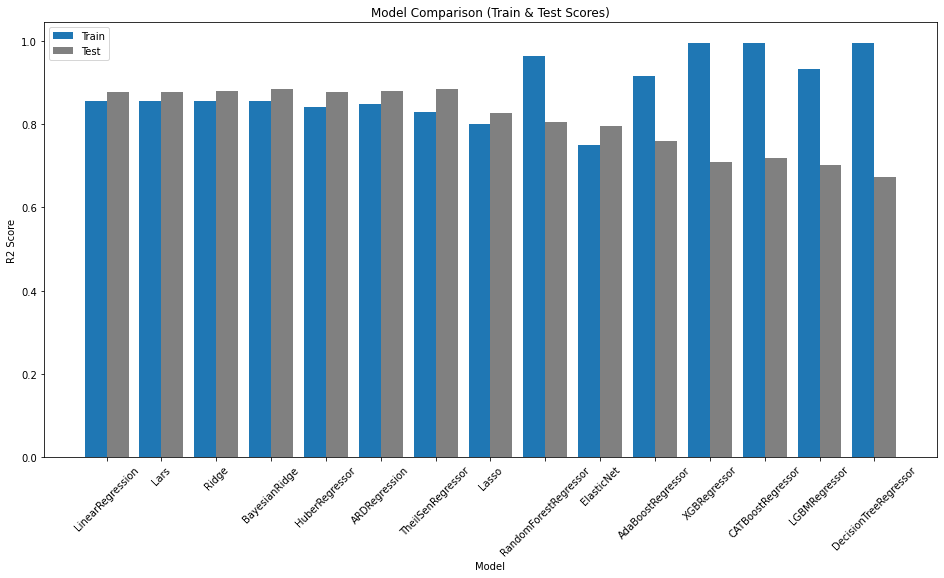

In [112]:
fig= plt.figure(figsize=(16,8))

x_axis = np.arange(len(df_models))

plt.bar(x_axis -0.2, df_models['r2_train'], width=0.4, label = 'Train')
plt.bar(x_axis +0.2, df_models['r2_test'], width=0.4, label = 'Test',color='gray')

plt.xlabel('Model')

plt.xticks(x_axis, df_models['model'],rotation=45)

plt.title('Model Comparison (Train & Test Scores)')

plt.ylabel('R2 Score')

plt.legend(['Train','Test'])

plt.show()

**Comparison of Models**

**LinearRegression (OLS)** fits a linear model with coefficients  to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

**Least-angle regression (LARS)** is a regression algorithm for high-dimensional data, At each step, it finds the feature most correlated with the target. When there are multiple features having equal correlation, instead of continuing along the same feature, it proceeds in a direction equiangular between the features

**Ridge regression** addresses some of the problems of Ordinary Least Squares (OLS) by imposing a penalty on the size of the coefficients. The ridge coefficients minimize a penalized residual sum of squares

**Bayesian regression** techniques can be used to include regularization parameters in the estimation procedure: the regularization parameter is not set in a hard sense but tuned to the data at hand. The advantages of Bayesian Regression are:It adapts to the data at hand and It can be used to include regularization parameters in the estimation procedure. Due to the Bayesian framework, the weights found are slightly different to the ones found by Ordinary Least Squares. However, Bayesian Ridge Regression is more robust to ill-posed problems.

**The Automatic Relevance Determination (as ARDRegression)** is a kind of linear model which is very similar to the Bayesian Ridge Regression, but that leads to smaller coefficients.

**The HuberRegressor** is different to Ridge because it applies a linear loss to samples that are classified as outliers. 


### 7. Hypertuning Models and Ensembling <a class="anchor" id="seven"></a>

**Hypertuning** is the process of changing the algorithms standard parameters in order to optimize performance. This can be done using GridSearchCV, which builds multiple models using different combinations and implements cross validation**

This process will be undertaken for the four best performing models (With the exception of Linear Regression and LARS that don't need tuning)

**Ridge**

In [113]:
param_grid = {
    'tol':[2,1,0.75,0.5,0.25,0.1,0.01,0.001],
    'alpha':[0.01,0.5,1,1.5,2],
    'max_iter':[10,25,50,100]
    
}


rid1 = Ridge()

rid1grid_search = GridSearchCV(estimator = rid1,param_grid = param_grid, cv = 5 ,  
                              n_jobs = -1, verbose = 2)

In [114]:
rid1grid_search.fit(X, y)
rid1grid_search.best_params_

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    2.4s finished


{'alpha': 0.5, 'max_iter': 10, 'tol': 2}

In [115]:
rid2 = Ridge()
rid2.set_params(**rid1grid_search.best_params_)

Ridge(alpha=0.5, max_iter=10, tol=2)

**Bayesian Ridge**

In [116]:
param_grid = {
    'tol':[0.1,0.01,0.001,0.0001,0.00001],
    'n_iter':[25,50,75,100,300],
    'alpha_1':[1e-04,1e-05,1e-06],
    'alpha_2':[1e-05,1e-06,1e-07],
    'lambda_1':[1e-05,1e-06,1e-07],
    'lambda_2':[1e-04,1e-05,1e-06]


}


br1 = linear_model.BayesianRidge()

br1grid_search = GridSearchCV(estimator = br1,param_grid = param_grid, cv = 5 ,  
                              n_jobs = -1, verbose = 2)

In [117]:
br1grid_search.fit(X, y)
br1grid_search.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 2025 candidates, totalling 10125 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2072 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 5320 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 9848 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 10125 out of 10125 | elapsed:   44.8s finished


{'alpha_1': 0.0001,
 'alpha_2': 1e-07,
 'lambda_1': 1e-07,
 'lambda_2': 0.0001,
 'n_iter': 25,
 'tol': 1e-05}

In [118]:
br2 = linear_model.BayesianRidge()
br2.set_params(**br1grid_search.best_params_)

BayesianRidge(alpha_1=0.0001, alpha_2=1e-07, lambda_1=1e-07, lambda_2=0.0001,
              n_iter=25, tol=1e-05)

**HuberRegressor**

In [119]:
param_grid = {
    'epsilon': [1.25,1.35,1.5,1.7,2,2.35],
    'max_iter':[50,100],
    'alpha':[0.1,0.01,0.001,0.0001],
    'tol':[1e-03,1e-04,1e-05]

}

h1 = HuberRegressor()

h1grid_search = GridSearchCV(estimator = h1,param_grid = param_grid, cv = 5 ,  
                              n_jobs = -1, verbose = 2)

In [120]:
h1grid_search.fit(X, y)
h1grid_search.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   11.0s finished


{'alpha': 0.1, 'epsilon': 2.35, 'max_iter': 50, 'tol': 0.001}

In [121]:
h2 = HuberRegressor()
h2.set_params(**h1grid_search.best_params_)

HuberRegressor(alpha=0.1, epsilon=2.35, max_iter=50, tol=0.001)

**ARDRegression**

In [122]:
param_grid = {
    'n_iter':[25,50,100,300],
    'tol':[0.01,0.001,0.0001,0.00001],
    'alpha_1':[1e-05,1e-06,1e-07,1e-08],
    'lambda_1':[1e-05,1e-06,1e-07,1e-08],
    'threshold_lambda':[50,100,1000]

}


ard1 = linear_model.ARDRegression()

ard1grid_search = GridSearchCV(estimator = ard1,param_grid = param_grid, cv = 5 ,  
                              n_jobs = -1, verbose = 2)

In [123]:
ard1grid_search.fit(X, y)
ard1grid_search.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 1228 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 2360 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 3820 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3833 out of 3840 | elapsed:  1.0min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  1.0min finished


{'alpha_1': 1e-05,
 'lambda_1': 1e-08,
 'n_iter': 25,
 'threshold_lambda': 1000,
 'tol': 0.01}

In [124]:
ard2 = linear_model.ARDRegression()
ard2.set_params(**ard1grid_search.best_params_)

ARDRegression(alpha_1=1e-05, lambda_1=1e-08, n_iter=25, threshold_lambda=1000,
              tol=0.01)

**Hyper-Tuned Models**

In [125]:
regressors = {
    "LinearRegression": LinearRegression(),
    "Lars": Lars(),
    "Ridge":Ridge(),
    "HuberRegressor": HuberRegressor(),
    "ARDRegression": ARDRegression(),
    "BayesianRidge": linear_model.BayesianRidge(),
    "Ridge_Tuned":rid2,
    "HuberRegressor_Tuned":h2,
    "ARDRegression_Tuned": ard2,
    "BayesianRidge_Tuned": br2,
}

In [126]:
df_models = pd.DataFrame(columns=['model', 'run_time', 'r2_train','r2_test','r2_cv','rmse'])

for key in regressors:

    print('*',key)

    start_time = time.time()

    regressor = regressors[key]
    model = regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores = cross_val_score(model, 
                             X, 
                             y,
                             scoring="r2", 
                             cv=10)

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'r2_train': regressor.score(X_train, y_train),
           'r2_test' : regressor.score(X_test, y_test),
           'r2_cv': np.mean(scores),
           'rmse': mean_squared_error(y_test, y_pred, squared=False)
           
    }

    df_models = df_models.append(row, ignore_index=True)

* LinearRegression
* Lars
* Ridge
* HuberRegressor
* ARDRegression
* BayesianRidge
* Ridge_Tuned
* HuberRegressor_Tuned
* ARDRegression_Tuned
* BayesianRidge_Tuned


**Hypertuning Results**

In [127]:
df_models=df_models.sort_values(by='r2_cv', ascending=False)
df_models

,model,run_time,r2_train,r2_test,r2_cv,rmse
7,HuberRegressor_Tuned,0.0,0.853883,0.882402,0.716408,5.694938
6,Ridge_Tuned,0.0,0.855501,0.878848,0.712775,5.780363
0,LinearRegression,0.0,0.855535,0.877655,0.712705,5.808755
1,Lars,0.0,0.855535,0.877655,0.712705,5.808755
2,Ridge,0.0,0.855403,0.879889,0.712703,5.755458
9,BayesianRidge_Tuned,0.0,0.854036,0.883519,0.711238,5.667819
5,BayesianRidge,0.0,0.854036,0.883519,0.711238,5.667818
3,HuberRegressor,0.01,0.841056,0.876390,0.691598,5.838688
8,ARDRegression_Tuned,0.0,0.845492,0.878874,0.674109,5.779742
4,ARDRegression,0.01,0.846841,0.878181,0.673999,5.796243


**Ensemble Methods**

**Stacking**: Uses several model outputs to build a final model for prediction

In [128]:
models = [('Linear Regression', LinearRegression()),
          ('LARS Regressor',Lars()),
          ('HuberRegressor_Tuned',HuberRegressor()),
          ('Ridge',Ridge()),
          ('ARDRegression_Tuned',ARDRegression()),
          ('BayesianRidge_Tuned',linear_model.BayesianRidge())]

sclf = StackingRegressor(estimators=models)

model = sclf.fit(X_train, y_train)
y_pred = model.predict(X_test)

**Voting**: Uses several model outputs and decides a final prediction based on a majority vote

In [129]:
models = [('Linear Regression', LinearRegression()),
          ('LARS Regressor',Lars()),
          ('HuberRegressor_Tuned',HuberRegressor()),
          ('Ridge',Ridge()),
          ('ARDRegression_Tuned',ARDRegression()),
          ('BayesianRidge_Tuned',linear_model.BayesianRidge())]

vclf = VotingRegressor(estimators=models)


### 8. Final Summary and Model Selection <a class="anchor" id="eight"></a>

We will now compare the linear models (original parameters and hyptertuned) as well as stacking/voting

In [130]:
regressors = {
    "LinearRegression": LinearRegression(),
    "Lars": Lars(),
    "Ridge":Ridge(),
    "HuberRegressor": HuberRegressor(),
    "ARDRegression": ARDRegression(),
    "BayesianRidge": linear_model.BayesianRidge(),
    "Ridge_Tuned":rid2,
    "HuberRegressor_Tuned":h2,
    "ARDRegression_Tuned": ard2,
    "BayesianRidge_Tuned": br2,
    'Stacking':sclf,
    'Voting':vclf
}

In [131]:
df_models = pd.DataFrame(columns=['model', 'run_time', 'r2_train','r2_test','r2_cv','rmse'])

for key in regressors:

    print('*',key)

    start_time = time.time()

    regressor = regressors[key]
    model = regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores = cross_val_score(model, 
                             X, 
                             y,
                             scoring="r2", 
                             cv=5)

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'r2_train': regressor.score(X_train, y_train),
           'r2_test' : regressor.score(X_test, y_test),
           'r2_cv': np.mean(scores),
           'rmse': mean_squared_error(y_test, y_pred, squared=False)
           
    }

    df_models = df_models.append(row, ignore_index=True)

* LinearRegression
* Lars
* Ridge
* HuberRegressor
* ARDRegression
* BayesianRidge
* Ridge_Tuned
* HuberRegressor_Tuned
* ARDRegression_Tuned
* BayesianRidge_Tuned
* Stacking
* Voting


In [132]:
df_models=df_models.sort_values(by='r2_cv', ascending=False)
df_models

,model,run_time,r2_train,r2_test,r2_cv,rmse
10,Stacking,0.05,0.851823,0.881906,0.785885,5.706945
6,Ridge_Tuned,0.0,0.855501,0.878848,0.783992,5.780363
0,LinearRegression,0.0,0.855535,0.877655,0.783952,5.808755
1,Lars,0.0,0.855535,0.877655,0.783952,5.808755
2,Ridge,0.0,0.855403,0.879889,0.783882,5.755458
9,BayesianRidge_Tuned,0.0,0.854036,0.883519,0.781915,5.667819
5,BayesianRidge,0.0,0.854036,0.883519,0.781915,5.667818
7,HuberRegressor_Tuned,0.0,0.853883,0.882402,0.781773,5.694938
11,Voting,0.01,0.854421,0.881530,0.776966,5.716021
3,HuberRegressor,0.0,0.841056,0.876390,0.752806,5.838688


In [133]:
print(f'''

The best performing model is {df_models.iloc[0,0]} 

''')



The best performing model is Stacking 




In [134]:
final_regressor_label= df_models.iloc[0,0]

In [135]:
for key in regressors:
    regressor = regressors[key]
    if key == df_models.iloc[0,0]:
        final_regressor= regressor
        

In [136]:
model = lr.fit(X_train, y_train)
y_pred = model.predict(X_test)

test=pd.DataFrame({'Actual value': y_test,'Predicted value': y_pred}).sort_values('Actual value').reset_index()


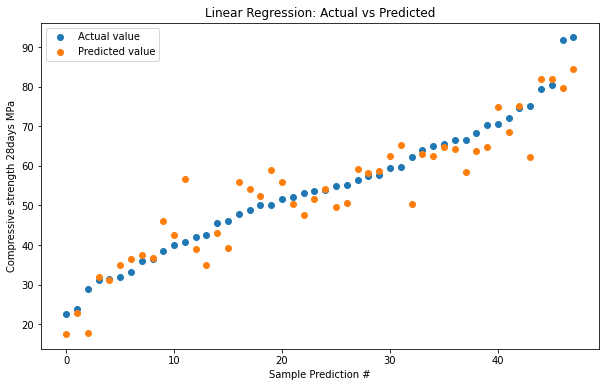

In [137]:
plt.figure(figsize=(10, 6))

plt.title("Linear Regression: Actual vs Predicted")

plt.scatter(test.index, test['Actual value'], label='Actual')

plt.scatter(test.index, test['Predicted value'], label='Predicted')

plt.xlabel("Sample Prediction #")

plt.ylabel("Compressive strength 28days MPa")

plt.legend(['Actual value','Predicted value'])

In [138]:
model = final_regressor.fit(X_train, y_train)
y_pred = model.predict(X_test)

test=pd.DataFrame({'Actual value': y_test,'Predicted value': y_pred}).sort_values('Actual value').reset_index()

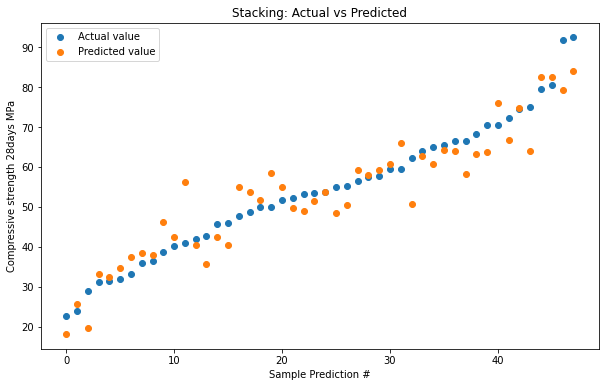

In [139]:
plt.figure(figsize=(10, 6))

plt.title( str(final_regressor_label)+": Actual vs Predicted")

plt.scatter(test.index, test['Actual value'], label='Actual')

plt.scatter(test.index, test['Predicted value'], label='Predicted')

plt.xlabel("Sample Prediction #")

plt.ylabel("Compressive strength 28days MPa")

plt.legend(['Actual value','Predicted value'])

In [140]:
## Performing 100 runs as a final check using all the data

final_check_lr=pd.DataFrame(columns=['Run #', 'R2', 'RMSE'])

for run in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    run_num=run+1
    lr=LinearRegression()
    regressor = lr
    model = lr.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores = cross_val_score(model, 
                             X, 
                             y,
                             scoring="r2", 
                             cv=10)

    row = {'Run #': run_num,
           'R2' : regressor.score(X_test, y_test),
           'RMSE': mean_squared_error(y_test, y_pred, squared=False)}
    
    final_check_lr = final_check_lr.append(row, ignore_index=True)


In [141]:
## Performing 100 runs as a final check using all the data

final_check_final_regressor=pd.DataFrame(columns=['Run #', 'R2', 'RMSE'])

for run in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    run_num=run+1
    regressor = final_regressor
    model = final_regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores = cross_val_score(model, 
                             X, 
                             y,
                             scoring="r2", 
                             cv=10)

    row = {'Run #': run_num,
           'R2' : regressor.score(X_test, y_test),
           'RMSE': mean_squared_error(y_test, y_pred, squared=False)}
    
    final_check_final_regressor = final_check_final_regressor.append(row, ignore_index=True)


In [142]:
print(f'''

After 100 runs:

Linear Regression R2:

Median= {round(final_check_lr['R2'].median(),3)}
Average = {round(final_check_lr['R2'].mean(),3)}


Linear Regression RMSE:

Median = {round(final_check_lr['RMSE'].median(),3)}
Average = {round(final_check_lr['RMSE'].mean(),3)} MPa


After 100 runs:

{final_regressor_label} R2:

Median = {round(final_check_final_regressor['R2'].median(),3)}
Average = {round(final_check_final_regressor['R2'].mean(),3)}


{final_regressor_label} RMSE:

Median = {round(final_check_final_regressor['RMSE'].median(),3)}
Average = {round(final_check_final_regressor['RMSE'].mean(),3)} MPa


''')



After 100 runs:

Linear Regression R2:

Median= 0.823
Average = 0.812


Linear Regression RMSE:

Median = 6.862
Average = 6.808 MPa


After 100 runs:

Stacking R2:

Median = 0.827
Average = 0.816


Stacking RMSE:

Median = 6.797
Average = 6.868 MPa





Text(0, 0.5, '# of runs')

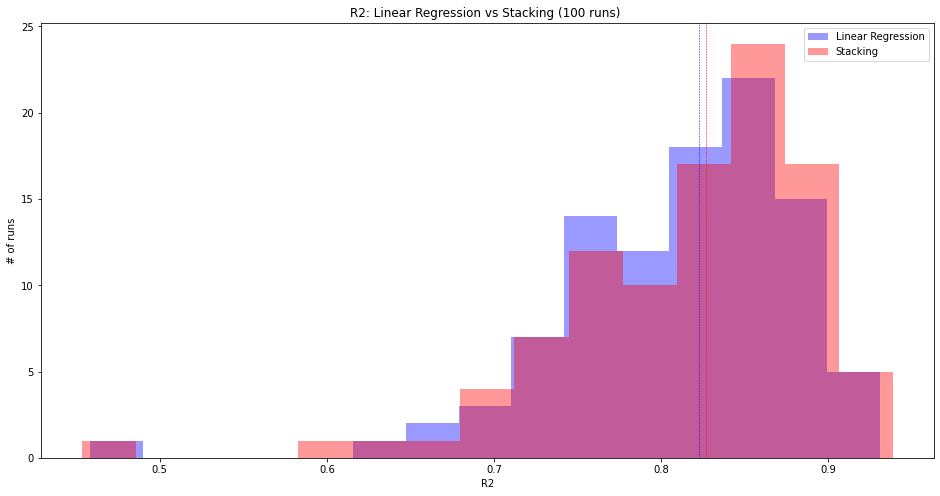

In [146]:
plt.figure(figsize=(16,8))

sns.distplot(final_check_lr["R2"],color='blue',bins=15, kde=False)

sns.distplot(final_check_final_regressor["R2"],color='red',bins=15, kde=False)

plt.legend(['Linear Regression',str(final_regressor_label)])


plt.axvline(x=final_check_lr["R2"].median(),color='blue',ls='--', lw=0.5)

plt.axvline(x=final_check_final_regressor["R2"].median(),color='red',ls='--', lw=0.5)


plt.title('R2: Linear Regression vs '+final_regressor_label +' (100 runs) ')

plt.ylabel('# of runs')


Text(0, 0.5, '# of runs')

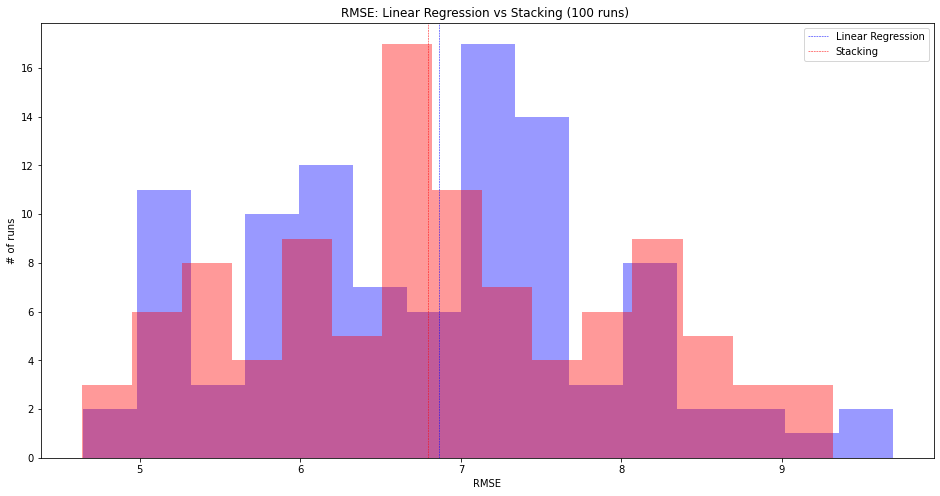

In [153]:
plt.figure(figsize=(16,8))

sns.distplot(final_check_lr["RMSE"],color='blue',bins=15,hist=True, kde=False)

sns.distplot(final_check_final_regressor["RMSE"],color='red',bins=15,hist=True, kde=False)



plt.axvline(x=final_check_lr["RMSE"].median(),color='blue',ls='--', lw=0.5)

plt.axvline(x=final_check_final_regressor["RMSE"].median(),color='red',ls='--', lw=0.5)

plt.legend(['Linear Regression',str(final_regressor_label)])


plt.title('RMSE: Linear Regression vs '+final_regressor_label+' (100 runs) ')

plt.ylabel('# of runs')


### 8. Appendix <a class="anchor" id="app"></a>

Below shows why non-linear is not appropriate for this small of a dataset, it's too sensitive to overfitting and needs more samples for a better learning curve

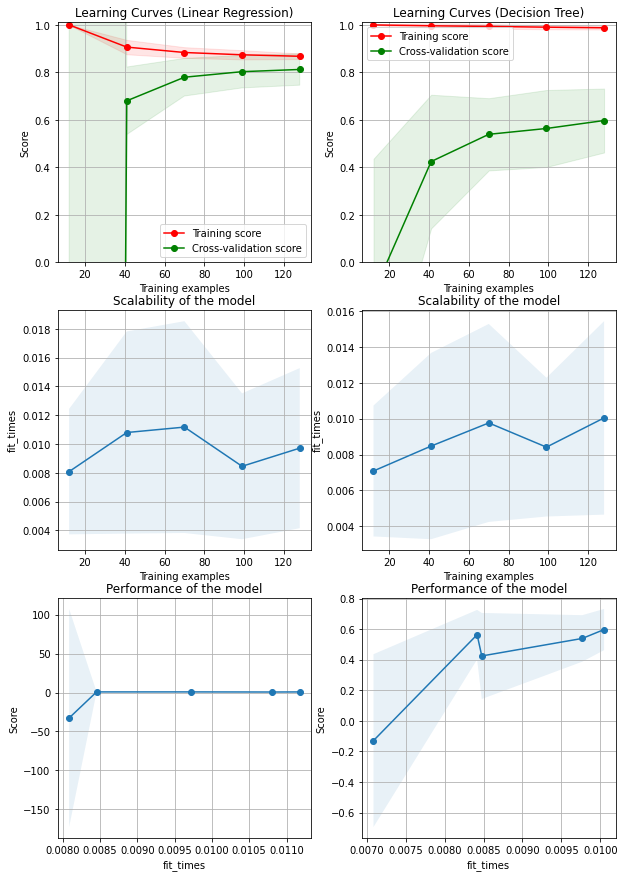

In [155]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

  
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))


title = "Learning Curves (Linear Regression)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = LinearRegression()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0, 1.01), cv=cv, n_jobs=4
)

title = "Learning Curves (Decision Tree)"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
estimator = DecisionTreeRegressor()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0, 1.01), cv=cv, n_jobs=4
)

plt.show()